In [1]:
import pandas as pd

# Load dataset
df = pd.read_excel("Online Retail.xlsx")

# Drop missing CustomerID entries (essential for RFM)
df.dropna(subset=['CustomerID'], inplace=True)

# Remove negative or zero transactions
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Step 1: Load and clean the dataset
# - Remove rows with missing CustomerID (RFM requires unique customer tracking)
# - Filter out returns and invalid transactions (Quantity and UnitPrice must be positive)
# - Compute TotalPrice as Quantity × UnitPrice for monetary analysis

In [2]:
import datetime as dt

# Snapshot date: one day after last invoice
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID to compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Step 2: RFM Feature Engineering
# - Recency: Days since last purchase
# - Frequency: Count of unique invoices
# - Monetary: Total spend per customer

In [3]:
# Score each metric from 1 (low) to 4 (high)
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Combine scores
rfm['RFM_Score'] = rfm[['R','F','M']].astype(int).sum(axis=1)

# Step 3: Assign RFM scores using quartile-based binning
# - Recency is inversely scored (lower days = higher score)
# - Frequency and Monetary are directly scored
# - RFM_Score is the sum of individual scores, used for segmentation

In [4]:
def segment_customer(score):
    if score >= 9: return 'Champions'
    elif score >= 7: return 'Loyal'
    elif score >= 5: return 'Potential'
    else: return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Step 4: Segment customers based on RFM_Score
# - Champions: High RFM (9–12)
# - Loyal: Moderate-high (7–8)
# - Potential: Mid-range (5–6)
# - At Risk: Low engagement (≤4)

C:\Users\rhipa\AppData\Local\Temp\ipykernel_21708\1643362640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis')


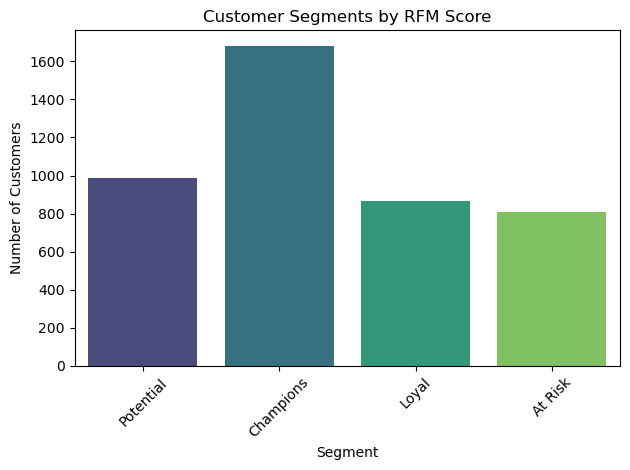

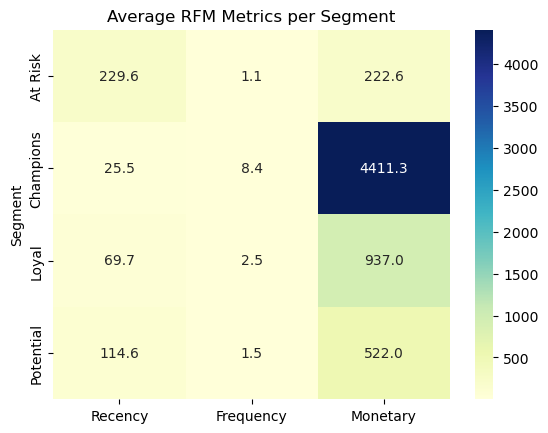

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart of segment distribution
sns.countplot(data=rfm, x='Segment', palette='viridis')
plt.title('Customer Segments by RFM Score')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap of average RFM values per segment
rfm_heatmap = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Average RFM Metrics per Segment')
plt.show()

### Marketing Recommendations

| Segment      | Strategy                                  |
|--------------|-------------------------------------------|
| Champions    | Early access, exclusive rewards           |
| Loyal        | Loyalty programs, referral incentives     |
| Potential    | Personalized offers, upselling bundles    |
| At Risk      | Re-engagement emails, win-back discounts  |

### Dataset Citation
Dataset sourced from the UCI Machine Learning Repository:  
Online Retail Dataset — https://archive.ics.uci.edu/dataset/352/online+retail  
Used solely for educational and analytical purposes in a reproducible academic context.

### Submission Note
This notebook was prepared as part of Task 3 for the Elevvo internship, demonstrating customer segmentation using RFM analysis. All code, logic, and annotations are original and designed for academic clarity and reproducibility.